# Plots

This notebook were used to generate all the plots on the paper, as well as some exclusive ones to help us get insights about the behaviour of the hiperparameters, but due limitations of space, were left out.

There are 4 groups of plots:
- convergence plots;
- scatter plots;
- heatmap plots;
- 3d landscape plots.

Also, at the end of the paper, the code used to calculate the coefficient of variation is presented.

In [1]:
import glob
import re
import matplotlib.backends.backend_pdf

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.mlab   as mlab
import seaborn           as sns

from scipy       import stats
from prettytable import PrettyTable
from itertools   import product

from scipy.stats import rankdata
from scipy.stats import wilcoxon

# used to generate 3d plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib           import cm
from matplotlib.ticker    import LinearLocator, FormatStrFormatter
from scipy                import interpolate

sns.set()
plt.style.use('default')
plt.rc('text', usetex=True)

# Definitions of variables

Some global variables, containing names of the datasets, number of folds and repetitions for each fold, and the log files path are defined here. They are global variables to allow their access to all plot generating cells.

All generated plots will be saved in pdf format inside the _save\_path_ folder.

Those variables can be modified if the user desires to visualise only some of the datasets, folds, repetitions, or search hyperparameter configurations. It is important to notice that, although their usage was intented to make easier the process of generating different plots, for some plots it will be needed to modify the cell code (i.e. for the heatmaps, if you change the number of datasets, you need to adjust the figure's size, number of rolls and number of columns).

It is recomended to change only **folds, reps, save_path**, as well as removing some **search_params** values (but not items).

In [2]:
dss = [
    'airfoil', 
    'concrete',
    'energyCooling',
    'energyHeating',
     'towerData',
     'wineRed',
     'wineWhite',
     'yacht'
]

_dss_labels = {
    'airfoil'       : 'Airfoil',
    'concrete'      : 'Concrete',
    'energyCooling' : 'Energy Cooling',
    'energyHeating' : 'Energy Heating',
    'towerData'     : 'Tower Data',
    'wineRed'       : 'Wine Red',
    'wineWhite'     : 'Wine White',
    'yacht'         : 'Yacth'
}
 
folds     = 5
reps      = 6

evol_path = './evolution_log/'
grid_path = './grid_log/'     

save_path = './plots/'

# Parameters explored on gridsearch
search_params = {
    'expolim'   : [1, 2, 3, 4, 5],
    'max_terms' : [2, 4, 6, 8, 10]    
}

# Definitions of auxiliary functions

To help preparing the plots, some auxiliary functions were defined below. They work by getting the execution informations of all runs (every repetition per every fold), and combining them by taking the mean or median of the RMSE over the generations or on the last generation, for different runs (train and test).

Also, there are some functions to help printing information in a better way. You should leave this as it is.

In [3]:
def get_conv_mean(params, ds):

    convergences = []
          
    for f in range(folds):
        for r in range(reps):            
            sufix = "-".join("=".join([k, str(v)]) for k, v in sorted(params.items()))
            
            resultsDF = pd.read_csv(f'{evol_path}{ds}-{f}-{r}-{sufix}.csv')
            
            conv = resultsDF['bestfit'] #[15:]
                
            convergences.append(conv)
    
    conv_mean = np.mean(convergences, axis=0)
    conv_std  = np.std(convergences, axis=0)
    
    return conv_mean, conv_std


def _get_clean_conv(line):
    gens_without_nan  = []
    rmses_without_nan = []

    highest_nan = 0
    for xc, yc in zip(range(len(line)), line):
        if yc>1e+150:
            highest_nan = xc + 1
    
    gens_without_nan = range(highest_nan, len(line))
    rmses_without_nan = line[highest_nan:]
    
    return gens_without_nan, rmses_without_nan


def get_final_rmse_raw(params, ds, metric='rmse_test'):
    final_rmses = []
    
    for f in range(folds):
        for r in range(reps):
            
            resultsDF = pd.read_csv(f'{grid_path}{ds}-{f}-{r}.csv')
            
            for k, v in params.items():
                resultsDF = resultsDF[resultsDF[k]==v]

            final_rmses.append(resultsDF[metric].tolist()[0])
    
            if np.isnan(resultsDF[metric].tolist()[0]):
                print('NaN on configuration', ds, f, r, params)

    return final_rmses


def get_final_rmse_mean(params, ds, metric='rmse_test'):
    final_rmses = get_final_rmse_raw(params, ds, metric)
    
    m = np.mean(final_rmses, axis=0)
    s = np.std(final_rmses, axis=0)
    
    return m, s


def get_final_rmse_median(params, ds, metric='rmse_test'):
    final_rmses = get_final_rmse_raw(params, ds, metric)
    
    m = np.median([f for f in final_rmses if not np.isnan(f)], axis=0)
    
    return m


def classification_means(metric='rmse_test'):
    means = np.zeros( (len(search_params['expolim']), len(search_params['max_terms']), folds*reps) )

    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
                
    for f in range(folds):
        for r in range(reps):

            rmse = -1

            for hp in hyperconfigs:
            
                resultsDF = pd.read_csv(f'{grid_path}{ds}-{f}-{r}.csv')
          
                for k, v in hp.items():
                    resultsDF = resultsDF[resultsDF[k]==v]
                    
                rmse = resultsDF[metric].tolist()[0]
                
                x_index = search_params['expolim'].index(resultsDF['expolim'].tolist()[0])
                y_index = search_params['max_terms'].index(resultsDF['max_terms'].tolist()[0])

                means[x_index][y_index][f*reps + r] = rmse
        
    return means


def dict_string(d):
    return '\n'.join([k+'='+str(v) for k, v in d.items()]).replace('expolim', 'degree_range').replace('_', '\_')


def check_pv(arg):
    x, y = arg
    if np.isnan(x) or np.isnan(y):
        return False
    return True

# Convergence plots

In this plot group, there are two cells. The first one lets you plot the convergence mean over **fold x reps** executions for a given configuration, showing the std deviation bar for each generation. This is useful to granularly inspect the convergence of each configuration. To change which configuration is used, modify the first line. Also, due to the large number of generations, the _error_step_ parameter determines the interval of generations to have their error bar plotted, to avoid a bloating of error bars.

The second plot shows the convergence mean for all configurations, highlighting the best and worse, to get a global view of the behaviour of the convergences. You should leave it as it is.

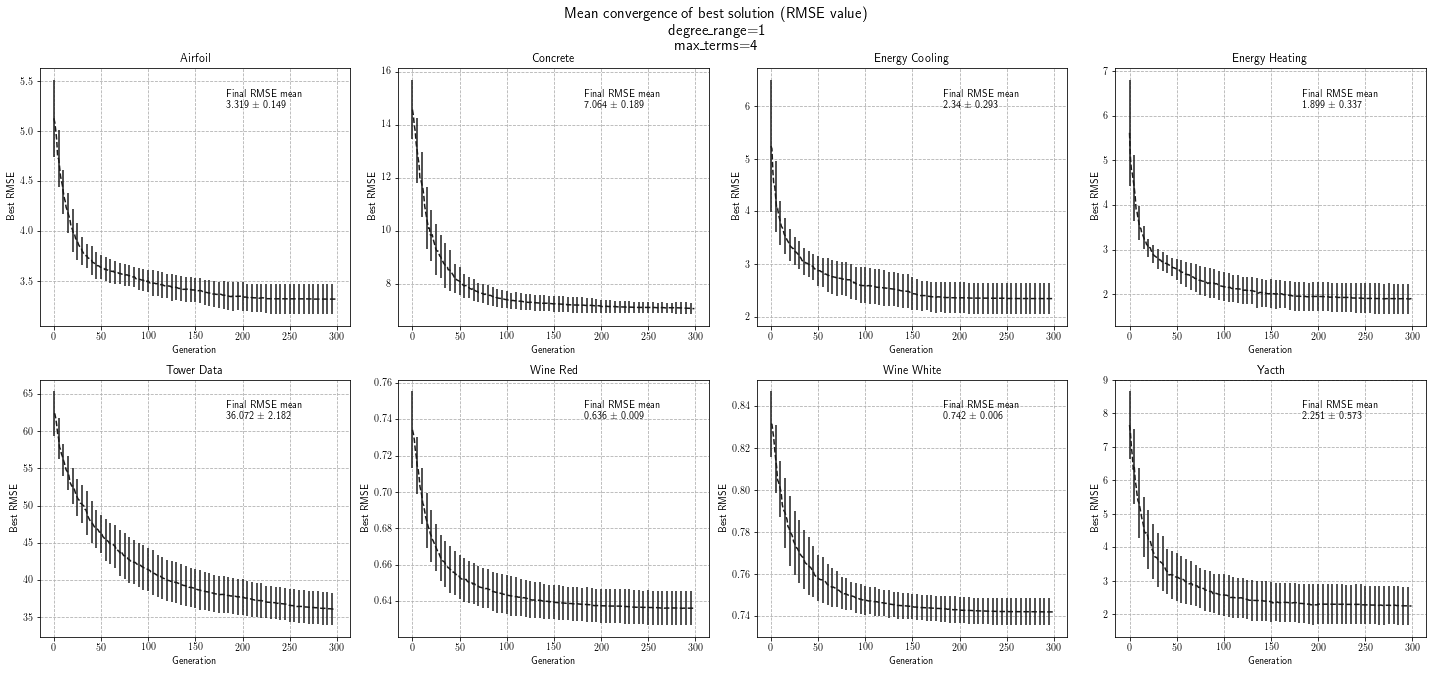

In [4]:
# CHANGE HERE ------------------------------
hp_config  = {'expolim':1, 'max_terms':4}
error_step = 5
# ------------------------------------------


fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for (ds, ax) in zip(dss, fig.axes):
    
    conv_mean, conv_std = get_conv_mean(hp_config, ds)

    ax.errorbar(
        range(len(conv_mean)),
        conv_mean,
        yerr=[c if i%error_step==0 else 0 for i, c in enumerate(conv_std)],
        fmt='--',
        c='k'
    )
    
    ax.set_title(_dss_labels[ds])
    
    ax.annotate( #mean of the best RMSE on the last generation
        f'Final RMSE mean\n{round(conv_mean[-1], 3)} \xb1 {round(conv_std[-1], 3)}',
        xy=(0.60, 0.85), xycoords='axes fraction'
    )
    
    ax.set_ylabel('Best RMSE')
    ax.set_xlabel('Generation')
    ax.grid(True, linestyle='--')
    
fig.suptitle(f'Mean convergence of best solution (RMSE value)\n{dict_string(hp_config)}',
            verticalalignment='top', fontsize = 15)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()

fig.savefig(f'{save_path}convergence-{hp_config}.pdf', bbox_inches='tight')

/home/galdeia/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/galdeia/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/galdeia/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


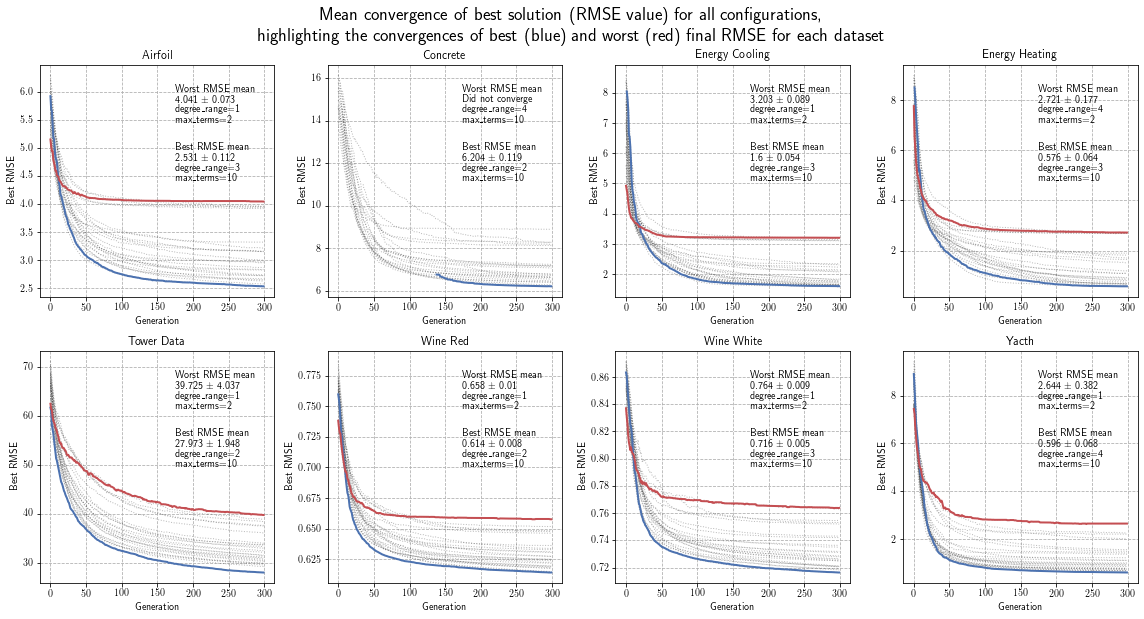

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

for (ds, ax) in zip(dss, fig.axes):
    
    conv_means      = []
    
    best_conv_mean  = [np.inf]
    best_conv_std   = np.inf
    best_hp         = {}
    
    worst_conv_mean = [-np.inf]
    worst_conv_std  = np.inf
    worst_hp        = {}
    
    #Creating all combinations of hyperparameters
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    for hp in hyperconfigs:
        
        conv_mean, conv_std = get_conv_mean(hp, ds)
        conv_means.append(conv_mean)
        
        if conv_mean[-1] < best_conv_mean[-1]:
            best_conv_mean = conv_mean
            best_conv_std  = conv_std
            best_hp = hp
            
        if conv_mean[-1] > worst_conv_mean[-1]:
            worst_conv_mean = conv_mean
            worst_conv_std  = conv_std
            worst_hp = hp
            
    for line in conv_means:
        
        # Filtering generations with NaNs to avoid messing up the plot y scale
        gens_without_nan, rmses_without_nan = _get_clean_conv(line)
        
        ax.plot(gens_without_nan, rmses_without_nan, 'k', alpha=0.3, linestyle='dotted', linewidth=1)

    gens_without_nan, rmses_without_nan = _get_clean_conv(best_conv_mean)
    ax.plot(gens_without_nan, rmses_without_nan,  c='b', linestyle='solid', linewidth=2)
    
    gens_without_nan, rmses_without_nan = _get_clean_conv(worst_conv_mean)
    ax.plot(gens_without_nan, rmses_without_nan, c='r', linestyle='solid', linewidth=2)
    
    ax.set_title(_dss_labels[ds])
    
    ax.annotate( #mean of the best RMSE on the last generation
        f'Best RMSE mean\n{round(best_conv_mean[-1], 3)} \xb1 {round(best_conv_std[-1], 3)}\n{dict_string(best_hp)}',
        xy=(0.575, 0.5), xycoords='axes fraction'
    )
    
    if worst_conv_mean[-1] < 1e+150:
        ax.annotate( #mean of the worst RMSE on the last generation
            f'Worst RMSE mean\n{round(worst_conv_mean[-1], 3)} \xb1 {round(worst_conv_std[-1], 3)}\n{dict_string(worst_hp)}',
            xy=(0.575, 0.75), xycoords='axes fraction'
        )
    else:
        ax.annotate( #message informing that it did not converged
            f'Worst RMSE mean\nDid not converge\n{dict_string(worst_hp)}',
            xy=(0.575, 0.75), xycoords='axes fraction'
        )
    
    ax.set_ylabel('Best RMSE')
    ax.set_xlabel('Generation')
    
    ax.grid(True, linestyle='--')
    
fig.suptitle(
    f'Mean convergence of best solution (RMSE value) for all configurations,\n\
highlighting the convergences of best (blue) and worst (red) final RMSE for each dataset',
    verticalalignment='top', fontsize = 18
)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

fig.savefig(f'{save_path}convergence-allconf.pdf', bbox_inches='tight')

# Scatter plots

Below are two groups of scatter plots, one for each hyperparameter fixed, showing the mean final RMSE (over **reps x folds**) when only the other hyperparameter is varying.

NaN on configuration concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN on configuration concrete 2 0 {'expolim': 5, 'max_terms': 10}


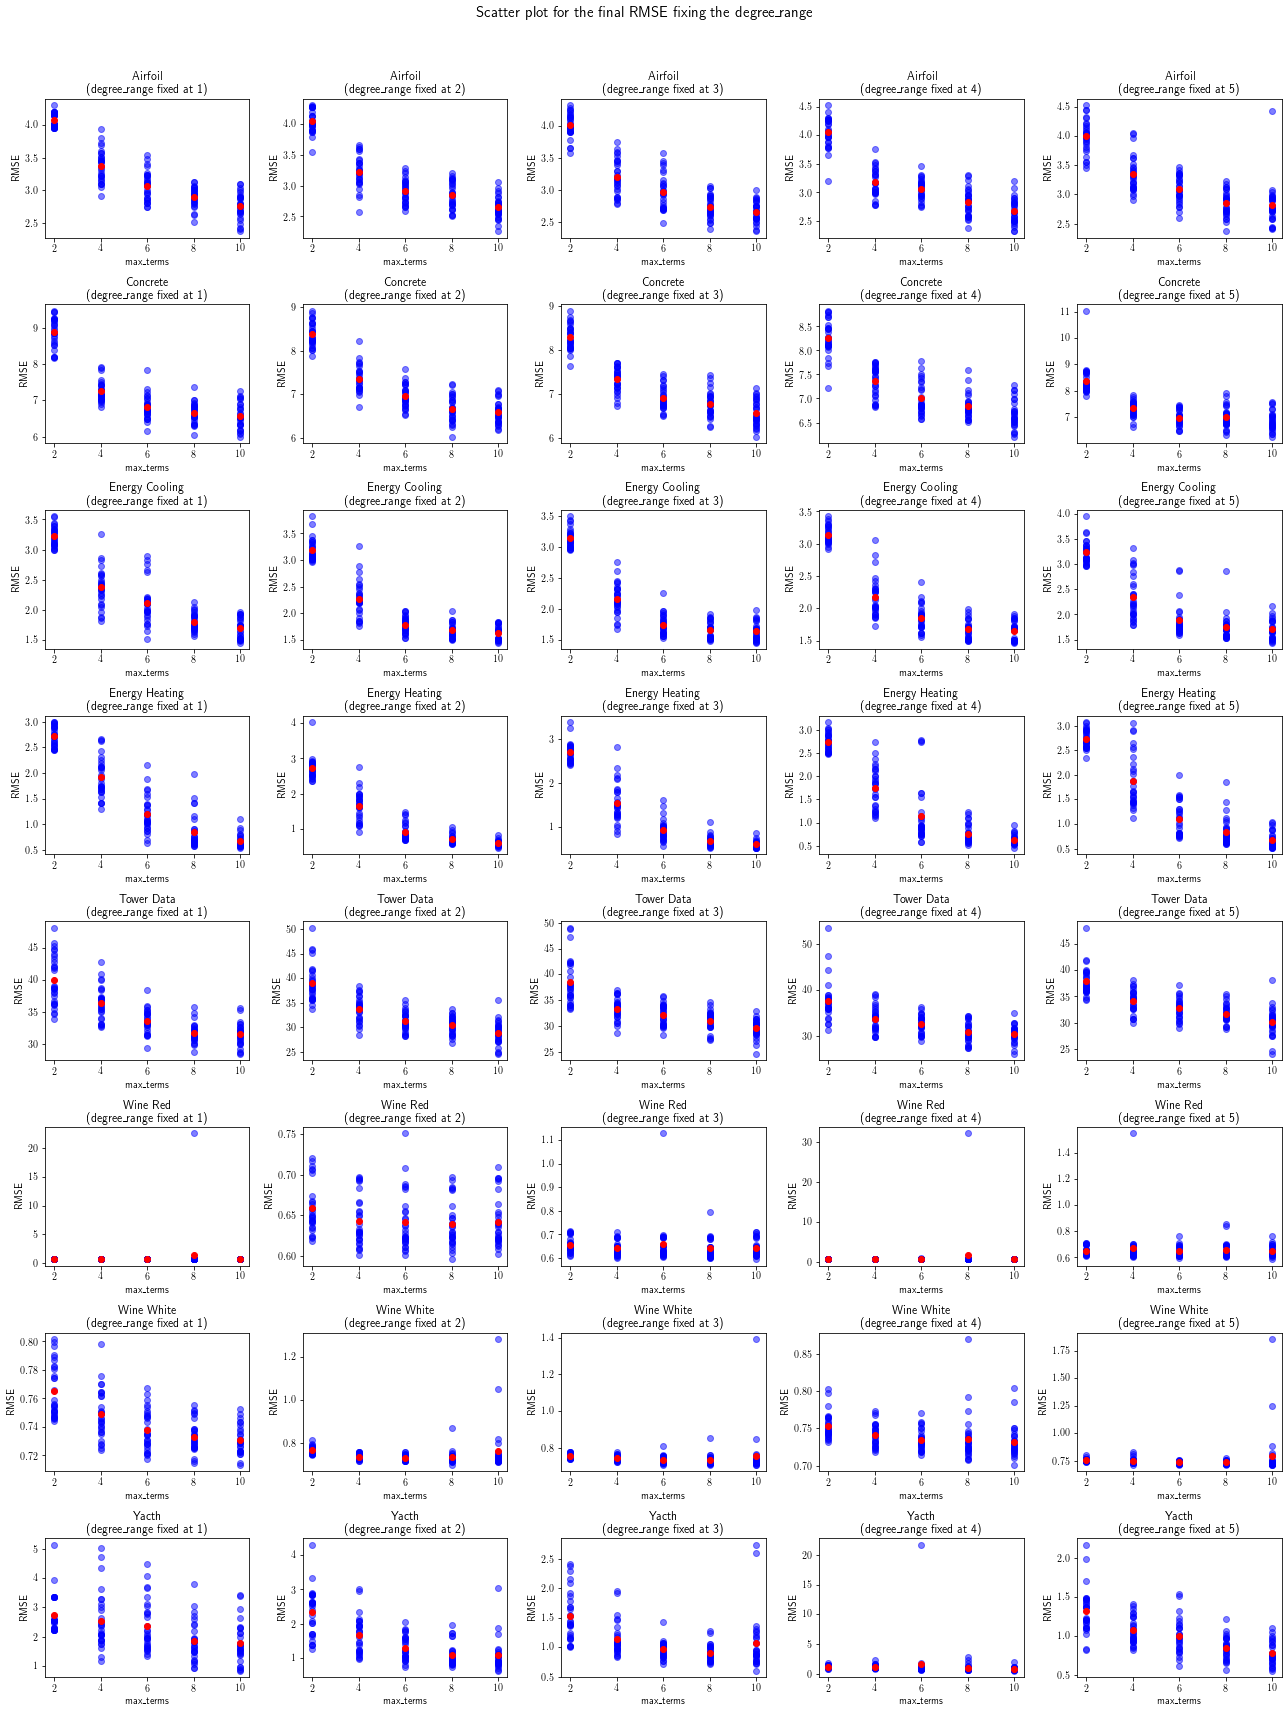

In [6]:
fig, axs = plt.subplots(nrows=len(dss), ncols=len(search_params['expolim']), figsize=(18, 25))

title = f'Scatter plot for the final RMSE fixing the degree\_range'
fig.suptitle(title, verticalalignment='top', fontsize = 15)

for i, ds in enumerate(dss):
    for j, expo_lim in enumerate(search_params['expolim']):

        x       = []
        y       = []
        medians = []
        for max_terms in search_params['max_terms']:
            rmses = get_final_rmse_raw({'expolim': expo_lim, 'max_terms':max_terms}, ds)
            
            medians.append(np.mean(rmses))
            
            for rmse in rmses:
                x.append(max_terms)
                y.append(rmse)
        
        axs[i][j].scatter(x, y, alpha=0.5, color='blue')
        axs[i][j].scatter(search_params['max_terms'], medians, color='red')
        axs[i][j].set_title(_dss_labels[ds] + f'\n(degree\_range fixed at {expo_lim})')
        axs[i][j].set_ylabel('RMSE')
        axs[i][j].set_xlabel('max\_terms')
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}scatter_exponent.pdf', bbox_inches='tight')

NaN on configuration concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN on configuration concrete 2 0 {'expolim': 5, 'max_terms': 10}


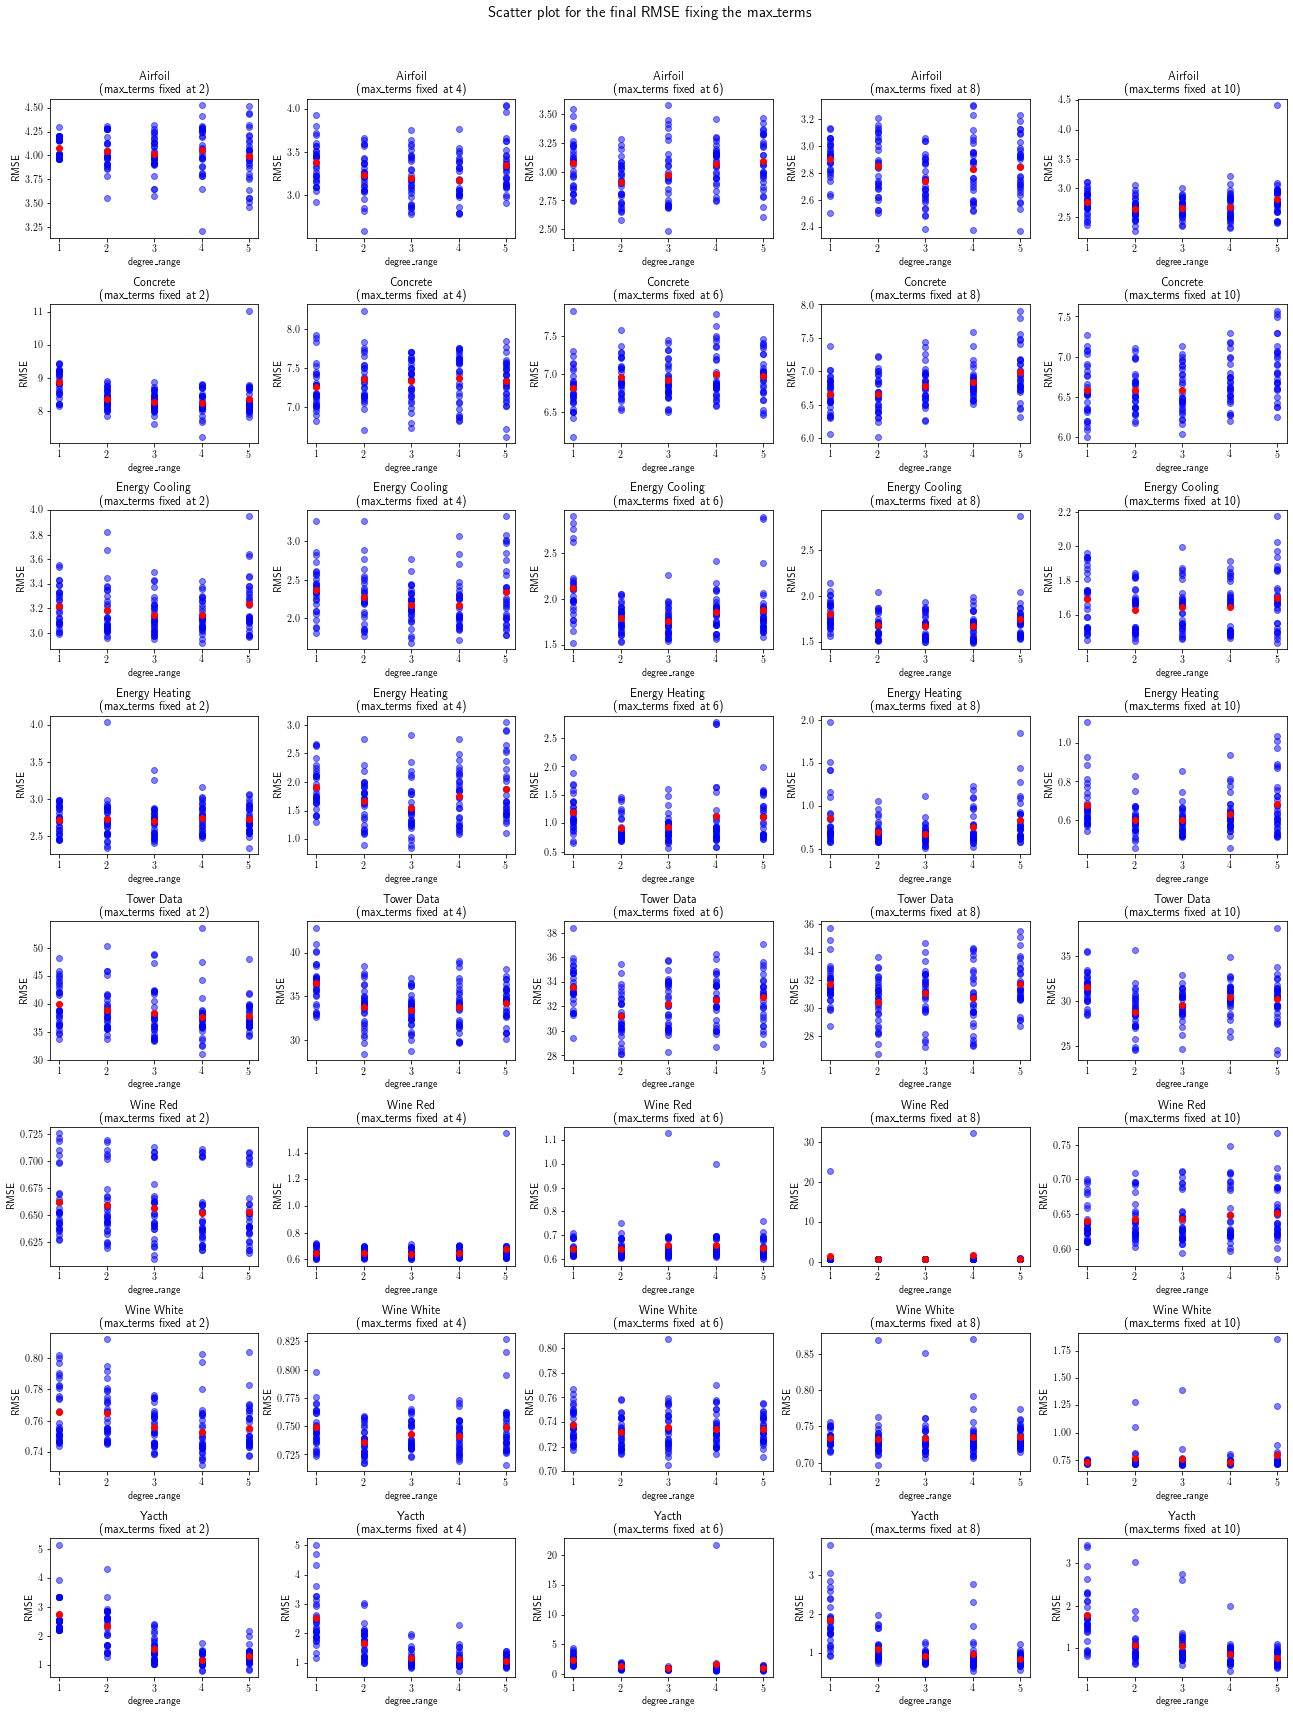

In [7]:
fig, axs = plt.subplots(nrows=len(dss), ncols=len(search_params['max_terms']), figsize=(18, 25))

title = f'Scatter plot for the final RMSE fixing the max\_terms'
fig.suptitle(title, verticalalignment='top', fontsize = 15)

for i, ds in enumerate(dss):
    for j, max_terms in enumerate(search_params['max_terms']):

        x       = []
        y       = []
        medians = []
        for expo_lim in search_params['expolim']:
            rmses = get_final_rmse_raw({'expolim': expo_lim, 'max_terms':max_terms}, ds)
            
            medians.append(np.mean(rmses))
            
            for rmse in rmses:
                x.append(expo_lim)
                y.append(rmse)
        
        axs[i][j].scatter(x, y, alpha=0.5, color='blue')
        axs[i][j].scatter(search_params['expolim'], medians, color='red')
        axs[i][j].set_title(_dss_labels[ds] + f'\n(max\_terms fixed at {max_terms})')
        axs[i][j].set_ylabel('RMSE')
        axs[i][j].set_xlabel('degree\_range')
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}scatter_maxterms.pdf', bbox_inches='tight')

# Heatmaps

Below are two heatmaps, showing every possible configuration. For each cell on each heatmap, the value is referring to the median final RMSE over **folds x reps** runs.

After evaluating all heatmap values, the best solution is selected and a wilcoxon single-rank test hypothesis is performed for every remaining configuration. Then, we loop for each cell creating it's label: for configurations where the p-value is higher than 0.05, it will be highlighted with an asterisc and bold text, otherwise it will be written in normal text.

The first heatmap shows the median RMSE, while the second shows the classification of each configuration.

NaN on configuration concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN on configuration concrete 2 0 {'expolim': 5, 'max_terms': 10}
NaN on configuration concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN on configuration concrete 2 0 {'expolim': 5, 'max_terms': 10}


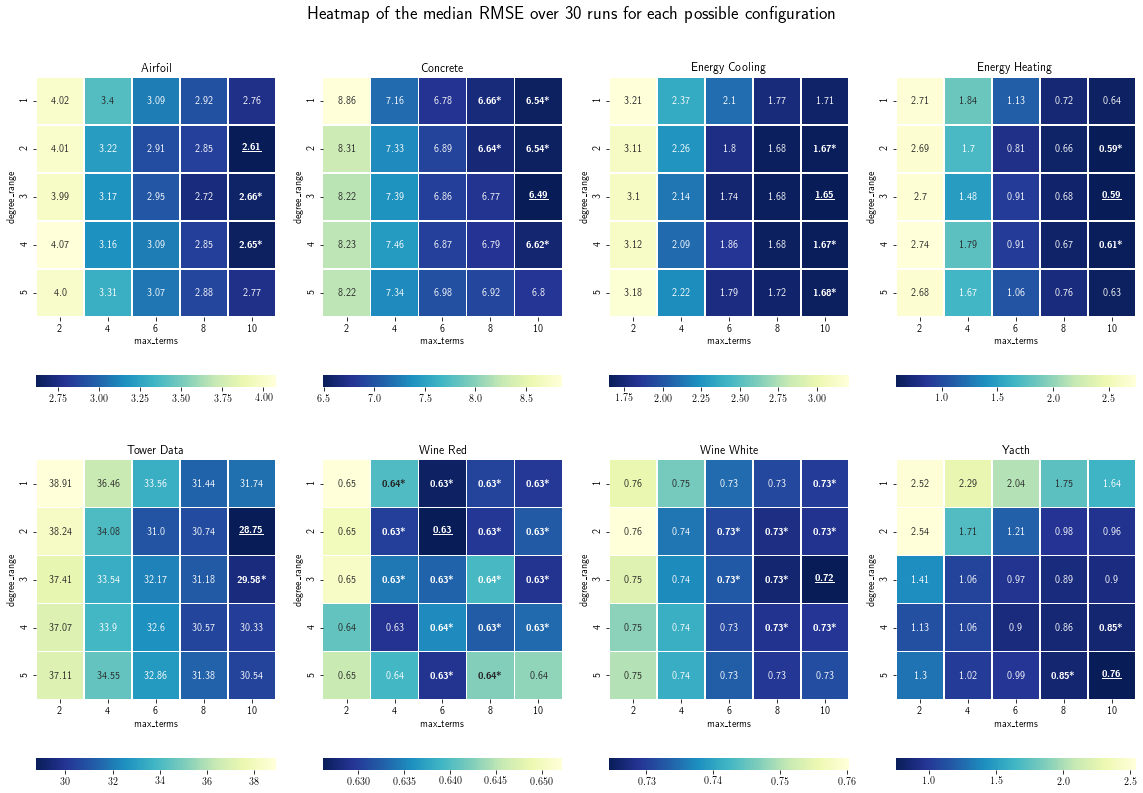

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 12))
    
title = f'Heatmap of the median RMSE over 30 runs for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
            
for ds, ax in zip(dss, fig.axes):
    grid   = []
    best        = {'expolim': search_params['expolim'][0], 'max_terms':search_params['max_terms'][0]}
    best_median = get_final_rmse_median(best, ds)
    
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    for hp1 in search_params['expolim']:
        
        line = []
        
        for hp2 in search_params['max_terms']:
        
            final_rmse_median = get_final_rmse_median({'expolim':hp1, 'max_terms':hp2}, ds)
            line.append(final_rmse_median)
            
            if final_rmse_median < best_median:
                best_median = final_rmse_median
                best = {'expolim':hp1, 'max_terms':hp2}
                
        grid.append(line)
    
    best_raw = get_final_rmse_raw(best, ds)
    
    # Creating the labels
    labels = []
    for i, hp1 in enumerate(search_params['expolim']):     
        line = []
        for j, hp2 in enumerate(search_params['max_terms']):
        
            if hp1 == best['expolim'] and hp2 ==best['max_terms']:
                line.append(r'\textbf{\underline{' + str(round(grid[i][j], 2)) + '}}')
            else:
                hp_raw = get_final_rmse_raw({'expolim':hp1, 'max_terms':hp2}, ds)
                
                hp_raw_filtered, best_raw_filtered = zip(* filter(check_pv, zip(hp_raw, best_raw)) )
                
                w, p = wilcoxon(hp_raw_filtered, best_raw_filtered)
                    
                if p>0.05:
                    line.append(r'\textbf{' + str(round(grid[i][j], 2)) +'*}')
                else:
                    line.append(r'' + str(round(grid[i][j], 2)) + '')
        labels.append(line)
        
    # darker represents a better RMSE
    sns.heatmap(
        data=np.array(grid), ax=ax, annot=np.array(labels), linewidths=.5,
        cmap="YlGnBu_r",
        square=True,
        cbar_kws={"orientation": "horizontal"}, fmt='',
        xticklabels=search_params['max_terms'], yticklabels=search_params['expolim'],
    )
    
    ax.set_title(_dss_labels[ds])
    ax.set_ylabel('degree\_range')
    ax.set_xlabel('max\_terms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}heatmap-medianRMSE.pdf', bbox_inches='tight')

NaN on configuration concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN on configuration concrete 2 0 {'expolim': 5, 'max_terms': 10}


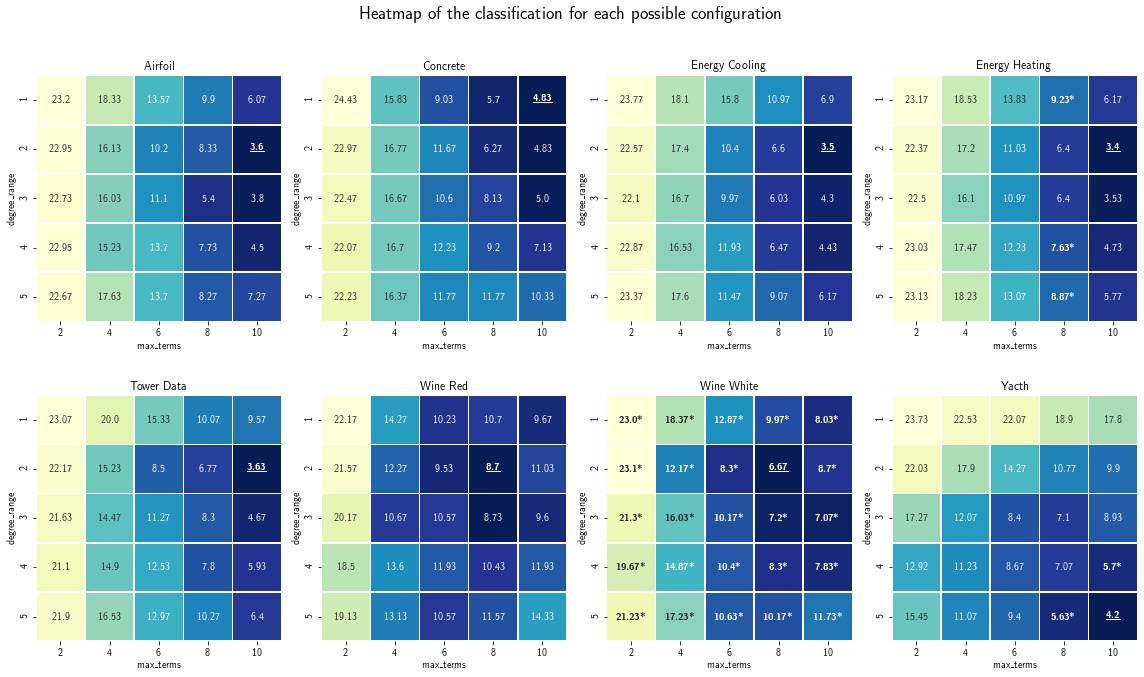

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))

title = f'Heatmap of the classification for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
       
for (ds, ax) in zip(dss, fig.axes):
    
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    means_classifications = classification_means()
    final_ranking = np.zeros( (len(search_params['expolim']), len(search_params['max_terms'])) )
    
    for i in range(reps*folds):
        
        fold_rep_ranking = rankdata(means_classifications[:, :, i]).reshape(means_classifications[:, :, i].shape)
    
        final_ranking += fold_rep_ranking
        
    grid= final_ranking/(reps*folds)

    best_i, best_j = np.unravel_index(grid.argmin(), grid.shape)
    
    best_raw_filtered = get_final_rmse_raw({'expolim': search_params['expolim'][best_i], 'max_terms' : search_params['max_terms'][best_j]}, ds)
    
    # creating the labels
    labels = []
    for i, hp1 in enumerate(search_params['expolim']):     
        line = []
        for j, hp2 in enumerate(search_params['max_terms']):
        
            if hp1 == search_params['expolim'][best_i] and hp2 ==search_params['max_terms'][best_j]:
                line.append(r'\textbf{\underline{' + str(round(grid[i][j], 2)) + '}}')
            else:
                hp_raw = get_final_rmse_raw({'expolim':hp1, 'max_terms':hp2}, ds)
                
                hp_raw_filtered, best_raw_filtered = zip(* filter(check_pv, zip(hp_raw, best_raw)) )
                
                w, p = wilcoxon(hp_raw_filtered, best_raw_filtered)
                    
                if p>0.05:
                    line.append(r'\textbf{' + str(round(grid[i][j], 2)) +'*}')
                else:
                    line.append(r'' + str(round(grid[i][j], 2)) + '')
        labels.append(line)
    
    
    sns.heatmap(
        data=np.array(grid), ax=ax, annot=np.array(labels), linewidths=.5,
        cbar=False,
        cmap="YlGnBu_r", fmt='',
        square=True,
        cbar_kws={"orientation": "horizontal"},
        xticklabels=search_params['max_terms'], yticklabels=search_params['expolim'],
    )
    
    ax.set_title(_dss_labels[ds])
    ax.set_ylabel('degree\_range')
    ax.set_xlabel('max\_terms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}heatmap-classifications.pdf', bbox_inches='tight')

# 3D plots

Landscapes plots of the same information contained on the heatmaps.

NaN on configuration concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN on configuration concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN on configuration concrete 2 0 {'expolim': 5, 'max_terms': 10}


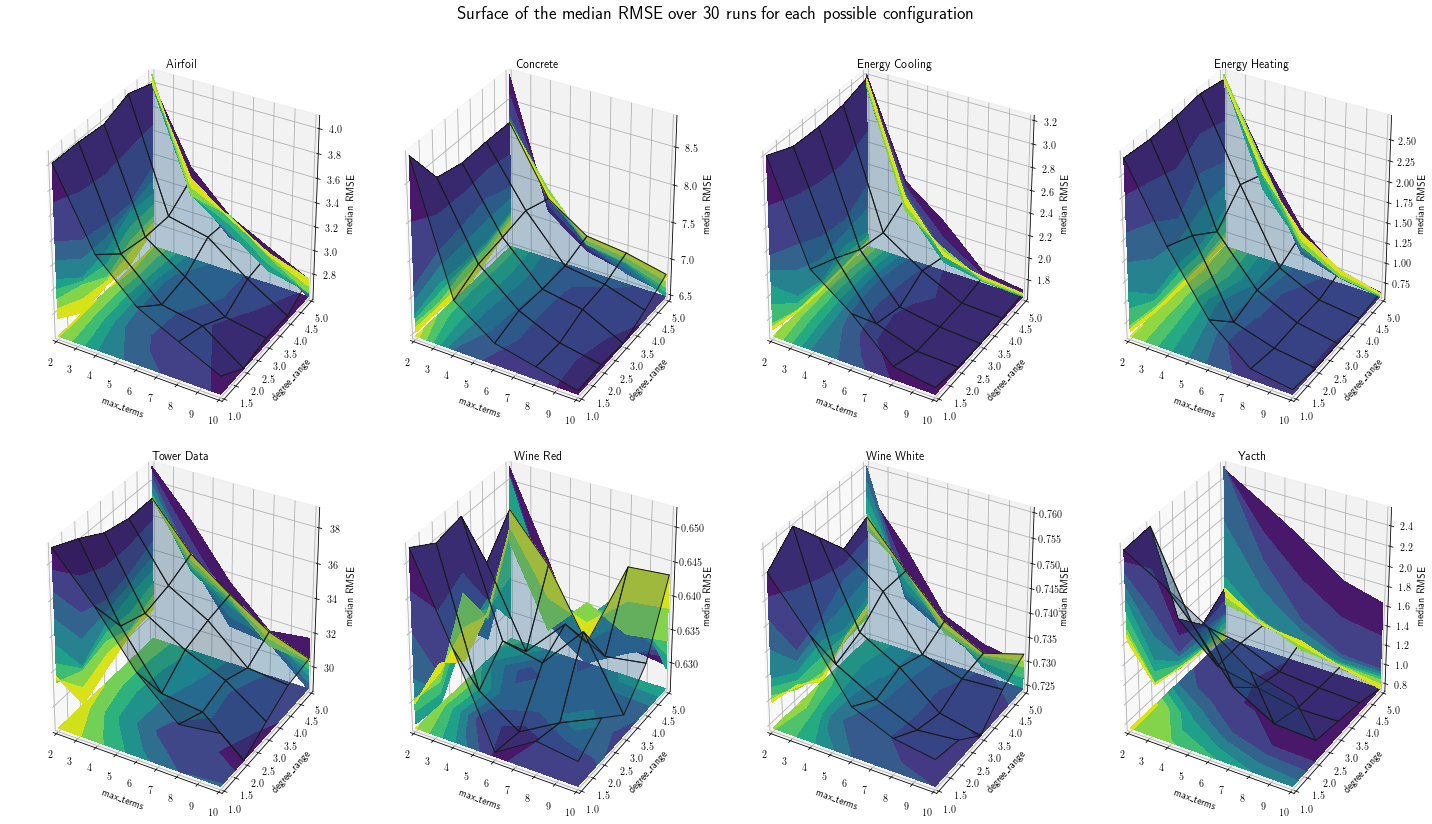

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), subplot_kw=dict(projection='3d'))
    
title = f'Surface of the median RMSE over 30 runs for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
            
for ds, ax in zip(dss, fig.axes):
    grid = []

    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    for hp1 in search_params['expolim']:
        
        line = []
        
        for hp2 in search_params['max_terms']:
        
            final_rmse_median = get_final_rmse_median({'expolim':hp1, 'max_terms':hp2}, ds)
            line.append(final_rmse_median)
            
        grid.append(line)
    
    grid = np.array(grid)

    X, Y = np.meshgrid(search_params['max_terms'], search_params['expolim'])
    
    f = interpolate.interp2d(X, Y, grid, kind='cubic')
    
    xnew = np.arange(0, 5, 0.25)
    ynew = np.arange(0, 5, 0.25)
    znew = f(xnew, ynew)
    
    Z = grid
    
    #surf = ax.plot_surface(xnew, ynew, znew, cmap=cm.coolwarm,
    surf = ax.plot_surface(X, Y, grid, rstride=1,cstride=1,alpha=0.3, edgecolors='k',
                       linewidth=1, antialiased=True)
    
    cset = ax.contourf(X, Y, Z, zdir='z', offset=min(grid.ravel()))
    cset = ax.contourf(X, Y, Z, zdir='x', offset=2)
    cset = ax.contourf(X, Y, Z, zdir='y', offset=5)
    
    ax.set_ylim(min(search_params['expolim']), max(search_params['expolim']))
    ax.set_xlim(min(search_params['max_terms']), max(search_params['max_terms']))
    
    ax.set_zlim(min(grid.ravel()), max(grid.ravel()))

    ax.set_title(_dss_labels[ds])
    ax.set_zlabel('median RMSE')
    ax.set_ylabel('degree\_range')
    ax.set_xlabel('max\_terms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}surface-medianRMSE.pdf', bbox_inches='tight')

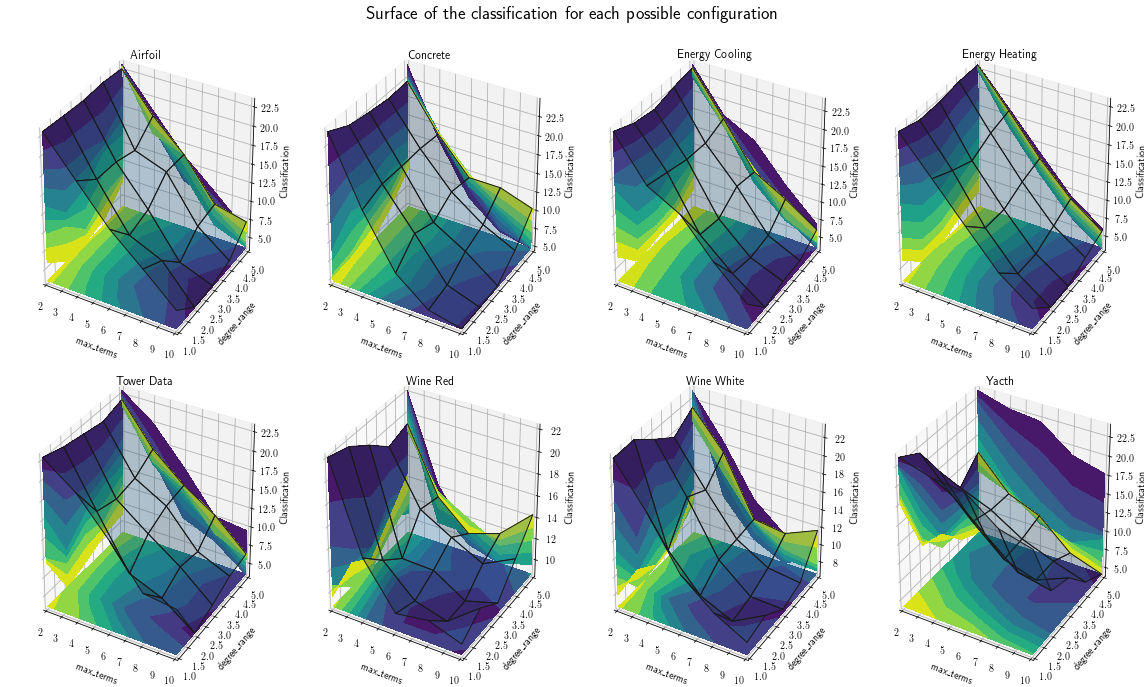

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), subplot_kw=dict(projection='3d'))

title = f'Surface of the classification for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
       
    
for (ds, ax) in zip(dss, fig.axes):
    
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    
    means_classifications =  np.zeros( (len(search_params['expolim']), len(search_params['max_terms']), folds*reps) )

    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
                
    for f in range(folds):
        for r in range(reps):

            rmse = -1

            for hp in hyperconfigs:
            
                resultsDF = pd.read_csv(f'{grid_path}{ds}-{f}-{r}.csv')
          
                for k, v in hp.items():
                    resultsDF = resultsDF[resultsDF[k]==v]
                    
                rmse = resultsDF['rmse_test'].tolist()[0]
                
                x_index = search_params['expolim'].index(resultsDF['expolim'].tolist()[0])
                y_index = search_params['max_terms'].index(resultsDF['max_terms'].tolist()[0])

                means_classifications[x_index][y_index][f*reps + r] = rmse
  
    final_ranking = np.zeros( (len(search_params['expolim']), len(search_params['max_terms'])) )
    
    for i in range(reps*folds):
        
        fold_rep_ranking = rankdata(means_classifications[:, :, i]).reshape(means_classifications[:, :, i].shape)
        final_ranking += fold_rep_ranking
        
    grid= final_ranking/(reps*folds)
    
    grid = np.array(grid)

    X, Y = np.meshgrid(search_params['max_terms'], search_params['expolim'])
    
    f = interpolate.interp2d(X, Y, grid, kind='cubic')
    
    xnew = np.arange(0, 5, 0.25)
    ynew = np.arange(0, 5, 0.25)
    znew = f(xnew, ynew)
    
    Z = grid
    
    #surf = ax.plot_surface(xnew, ynew, znew, cmap=cm.coolwarm,
    surf = ax.plot_surface(X, Y, grid, rstride=1,cstride=1,alpha=0.3, edgecolors='k',
                       linewidth=1, antialiased=True)
    
    cset = ax.contourf(X, Y, Z, zdir='z', offset=min(grid.ravel()))
    cset = ax.contourf(X, Y, Z, zdir='x', offset=2)
    cset = ax.contourf(X, Y, Z, zdir='y', offset=5)
    
    #ax.view_init(60, 35)
    ax.set_ylim(min(search_params['expolim']), max(search_params['expolim']))
    ax.set_xlim(min(search_params['max_terms']), max(search_params['max_terms']))
    
    ax.set_zlim(min(grid.ravel()), max(grid.ravel()))

    ax.set_title(_dss_labels[ds])
    ax.set_zlabel('Classification')
    ax.set_ylabel('degree\_range')
    ax.set_xlabel('max\_terms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}surface-classifications.pdf', bbox_inches='tight')

# Variance analysis

This is where the proposed coefficient of variance analysis is performed. A better description can be found on the paper.

In [12]:
for k, v in search_params.items():
    print(f'Varying {k} = {v}')

    for ds in dss:
        
        print(ds)
        
        #Every hyperparameter configuration, isolating the one being varied
        hyperconfigs_minus_one = {**search_params}
        hyperconfigs_minus_one.pop(k)
        
        keys, values = zip(*hyperconfigs_minus_one.items())
        hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]

        cvs = []
        
        for hp in hyperconfigs:
            
            median_rmses = [get_final_rmse_median({**hp, **{k : varying}}, ds) for varying in v]
            
            final_std  = np.std(median_rmses) 
            final_mean = np.mean(median_rmses)
            
            cvs.append(final_std/final_mean)

        print(f'CVs: {[str(round(cv, 3)) for cv in cvs] + \
            [str(round(np.mean(cvs), 3)) +  " pm " + str(round(np.std(cvs), 3))]}')
    
        print('--------------------------------------------------')

Varying expolim = [1, 2, 3, 4, 5]
airfoil
CVs: ['0.007', '0.028', '0.026', '0.023', '0.023', '0.021 pm 0.007']
--------------------------------------------------
concrete
NaN on configuration concrete 2 0 {'max_terms': 10, 'expolim': 4}
NaN on configuration concrete 4 4 {'max_terms': 10, 'expolim': 4}
NaN on configuration concrete 0 1 {'max_terms': 10, 'expolim': 5}
NaN on configuration concrete 2 0 {'max_terms': 10, 'expolim': 5}
CVs: ['0.03', '0.013', '0.01', '0.015', '0.017', '0.017 pm 0.007']
--------------------------------------------------
energyCooling
CVs: ['0.014', '0.044', '0.069', '0.02', '0.012', '0.032 pm 0.022']
--------------------------------------------------
energyHeating
CVs: ['0.008', '0.074', '0.121', '0.051', '0.036', '0.058 pm 0.038']
--------------------------------------------------
towerData
CVs: ['0.019', '0.03', '0.026', '0.011', '0.033', '0.024 pm 0.008']
--------------------------------------------------
wineRed
CVs: ['0.006', '0.007', '0.006', '0.008', '